In the previous notebook we set up a HMM and forward computing process. This one will extend that idea, with a few differences. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple M1/M2 GPU via MPS")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")

✅ Using Apple M1/M2 GPU via MPS


In [3]:

# experimenting with torch
# unsqueeze function
x = torch.tensor([1, 2, 3, 4])
c = torch.unsqueeze(x, 0)  # adds a dimension at index 0
print(c)
b = torch.unsqueeze(x, 1)  # adds a dimension at index 1
print(b)

       # Hidden State Ha   Hb    Hc
transition_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])

       # emissions  # A   B    C
emission_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])


pi = torch.tensor([0.3,0.4,0.3])

eta = torch.tensor([0.9,0.05,0.05])

tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


In [4]:
def compute_msp_matrices(A: torch.Tensor, B: torch.Tensor):
    """
    Given HMM transition matrix A [N, N] and emission matrix B [N, M],
    return a list of MSP matrices T_k, one for each observation symbol k.
    """
    N, M = B.shape
    T_list = []
    
    for k in range(M):  # loop over observation symbols
        emission_col = B[:, k]                      # shape (N,)
        T_k = A * emission_col.unsqueeze(0)         # broadcast multiply to shape (N, N)
        T_list.append(T_k)
    print("msp_matrices:", T_list)
    return T_list  # list of [N x N] tensors, each is T_k

def generate_store_token_belief(T_list,pi:torch.tensor,eta,cycle,seed=None):
     token = []
     belief = []
     store = []
     eta = eta
     print("pi:", pi.shape[0])
     if seed is not None:
          torch.manual_seed(seed)
     for _ in range(cycle):
          dice = np.random.choice(pi.shape[0])
          #print("dice:", dice)
          t_x = T_list[dice]
          
          eta = eta @ t_x
          eta = eta / eta.sum()
          
          token.append(pi[dice])
          belief.append(eta)
          store.append(get_cartesian_from_barycentric(eta))
     token = torch.tensor(token)
     belief = torch.stack(belief)
     return token,belief,store

# helper function
def get_cartesian_from_barycentric(b):
    t = np.transpose(np.array([[0,0],[1,0],[0.5, np.sqrt(3)/2]])) # Triangle
    return t.dot(b)

print(get_cartesian_from_barycentric(eta))

def plot_beliefs_on_simplex(beliefs: torch.Tensor, title="Belief Trajectory"):
    assert beliefs.shape[1] == 3, "Only works for 3-state HMM"

    # Make triangle float32 to match beliefs
    v0 = torch.tensor([0.0, 0.0], dtype=beliefs.dtype)
    v1 = torch.tensor([1.0, 0.0], dtype=beliefs.dtype)
    v2 = torch.tensor([0.5, torch.sqrt(torch.tensor(3.0, dtype=beliefs.dtype)) / 2], dtype=beliefs.dtype)
    triangle = torch.stack([v0, v1, v2])  # [3, 2]
    #print("triangle:", triangle)
    # Convert belief vectors to xy
    xy_coords = beliefs @ triangle  # [T, 2]
    #print("xy_coords:", xy_coords.shape)
    print("examples:", xy_coords[0:3])
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(*zip(*torch.cat([triangle, triangle[0].unsqueeze(0)], dim=0)), color='k', lw=1)
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], s=6, c=range(len(beliefs)), cmap='viridis')
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


[0.075      0.04330127]


Notes that helps you quickly know the shape of the tensors.

The T_list, or the msp_matrices, are stacks of three corresponding msp matrix. 

Let the generation string length be x, then:
the tokens are simply 1 dim
the tokens are 2 dim, (3,x)

In [19]:
t_list = compute_msp_matrices(transition_matrix, emission_matrix)
tokens, beliefs,store = generate_store_token_belief(t_list, pi=pi,eta=eta, cycle=5000)
tokens = tokens.to(device)
beliefs = beliefs.to(device)
print("token.shape:", tokens.shape)
print("example token:", tokens[0:5])
print("belief.shape:", beliefs.shape)
print("example belief:", beliefs[0:5])

msp_matrices: [tensor([[0.8100, 0.0025, 0.0025],
        [0.0450, 0.0450, 0.0025],
        [0.0450, 0.0025, 0.0450]]), tensor([[0.0450, 0.0450, 0.0025],
        [0.0025, 0.8100, 0.0025],
        [0.0025, 0.0450, 0.0450]]), tensor([[0.0450, 0.0025, 0.0450],
        [0.0025, 0.0450, 0.0450],
        [0.0025, 0.0025, 0.8100]])]
pi: 3
token.shape: torch.Size([5000])
example token: tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000], device='mps:0')
belief.shape: torch.Size([5000, 3])
example belief: tensor([[0.9875, 0.0062, 0.0062],
        [0.9931, 0.0034, 0.0034],
        [0.9935, 0.0033, 0.0033],
        [0.9935, 0.0033, 0.0033],
        [0.9935, 0.0033, 0.0033]], device='mps:0')


In [ ]:

class ContinuousHMMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens, beliefs, seq_len):
        self.tokens = tokens
        self.beliefs = beliefs
        self.seq_len = seq_len
        self.length = len(tokens) - seq_len - 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.tokens[idx : idx + self.seq_len]           # [seq_len]
        y = self.tokens[idx + 1 : idx + self.seq_len + 1]   # [seq_len]
        
        b = self.beliefs[idx + 1 : idx + self.seq_len + 1]  # [seq_len, 3]
        return x, y, b
    
def training(model, ds, dl, epochs=20, lr=1e-4, device=device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for inputs, labels, _ in dl:  # from the dataset
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # [batch, seq_len, vocab_size]
            loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), labels.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}: total loss = {total_loss:.4f}")

In [20]:

class RNN(nn.Module):
    def __init__(self, vocab_size = 3, emb_dim=32, hidden_dim=64, rnn_type="GRU"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        # Choose between RNN / LSTM / GRU
        if rnn_type == "GRU":
            self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        elif rnn_type == "RNN":
            self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Choose from: 'GRU', 'LSTM', 'RNN'")

        self.output_proj = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        """
        x: [B, T] — token indices
        returns: [B, T, vocab_size] — logits for next-token prediction
        """
        x = self.embedding(x)           # [B, T, D]
        rnn_out, _ = self.rnn(x)        # [B, T, H]
        return self.output_proj(rnn_out)  # [B, T, vocab_size]

In [21]:
#model = CNN(vocab_size=3)
model = RNN()
model.output_proj

#model.output_proj

Linear(in_features=64, out_features=3, bias=True)

In [23]:
tokens = tokens.long()
ds = ContinuousHMMDataset(tokens, beliefs, seq_len=700)
dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=False)
training(model,ds,dl)
torch.save(model.state_dict(), "RNN.pth")


Epoch 1: total loss = 28.6634
Epoch 2: total loss = 15.2699


KeyboardInterrupt: 

In [ ]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

model = RNN()
model.load_state_dict(torch.load("RNN.pth"))
model = model.to(device)
model.eval()

# register forward hooks on the layers of choice
h1 = model.output_proj.register_forward_hook(getActivation('output_proj'))
#h2 = model.conv2.register_forward_hook(getActivation('conv2'))
#h3 = model.conv1.register_forward_hook(getActivation('conv1'))

output_list, conv1_list, conv2_list = [], [], []
# go through all the batches in the dataset
X, y, true_belief = next(iter(dl))
  # forward pass -- getting the outputs
out = model(X)
  # collect the activations in the correct list
conv1_list.append(activation['output_proj'])
#conv1_list.append(activation['conv1'])
  #comp_list.append(activation['comp']
	
# detach the hooks
h1.remove()
#h2.remove()
#h3.remove()

/var/folders/lr/pld8m16d3c555_tynzkv73p80000gn/T/ipykernel_78758/1670960374.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNN.pth"))

In [17]:

def probe_rnn_hidden(model, dataloader, true_belief, hook_layer_name="rnn", device="cpu"):
    model = model.to(device)
    model.eval()

    # === Capture activation in this dictionary ===
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            # For GRU/LSTM, output = (output_seq, hidden_state)
            if isinstance(output, tuple):
                activation[name] = output[0].detach()  # [B, T, H]
            else:
                activation[name] = output.detach()      # [B, T, H]
        return hook

    # === Register forward hook on the RNN layer ===
    handle = getattr(model, hook_layer_name).register_forward_hook(get_activation(hook_layer_name))

    # === Forward pass on 1 batch ===
    X, _, _ = next(iter(dataloader))
    X = X.to(device)
    true_belief = true_belief.to(device)
    _ = model(X)  # triggers the hook

    # === Cleanup the hook ===
    handle.remove()

    # === Prepare activations and beliefs for regression ===
    reps = activation[hook_layer_name]         # [B, T, H]
    reps = reps.reshape(-1, reps.shape[-1])    # [B*T, H]
    beliefs = true_belief.reshape(-1, 3)       # [B*T, 3]

    # === Linear regression and plotting ===
    X_np = reps.detach().cpu().numpy()
    Y_np = beliefs.detach().cpu().numpy()
    probe = LinearRegression().fit(X_np, Y_np)
    Y_pred = probe.predict(X_np)

    pred_tensor = torch.tensor(Y_pred, dtype=torch.float32)
    plot_beliefs_on_simplex(pred_tensor, title="Probed Beliefs from RNN Hidden States")

/var/folders/lr/pld8m16d3c555_tynzkv73p80000gn/T/ipykernel_78758/3955481216.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("RNN.pth"))


examples: tensor([[0.5475, 0.2987],
        [0.5920, 0.2796],
        [0.5483, 0.2858]])


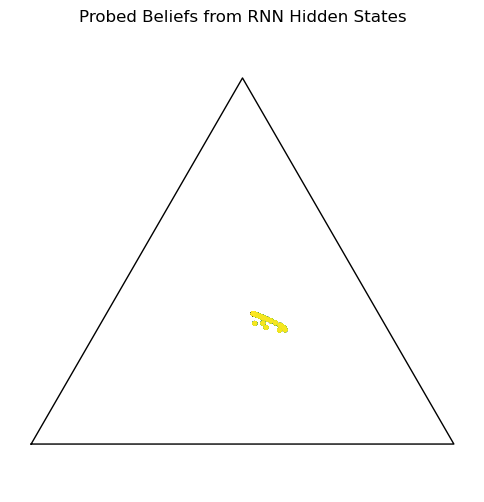

In [18]:
model = RNN(vocab_size=3, emb_dim=32, hidden_dim=64, rnn_type="LSTM")
model.load_state_dict(torch.load("RNN.pth"))
probe_rnn_hidden(model, dataloader=dl, true_belief=true_belief, device=device)

In [16]:
# Convert conv1 output from [B, C, T] to [B, T, C]
conv1 = conv1_list[0].permute(0, 2, 1)  # [B, T, C]

# Flatten
X = conv1.reshape(-1, conv1.shape[-1]).detach().cpu().numpy()        # [B*T, C]
Y = true_belief.reshape(-1, 3).detach().cpu().numpy()                # [B*T, 3]

# Linear regression
probe = LinearRegression()
probe.fit(X, Y)
Y_pred = probe.predict(X)

# Convert prediction back to tensor
pred_tensor = torch.tensor(Y_pred, dtype=torch.float32)

# Plot on simplex
plot_beliefs_on_simplex(pred_tensor, title="Probed Beliefs from CNN conv1")

ValueError: Found input variables with inconsistent numbers of samples: [192, 38400]

examples: tensor([[0.4984, 0.3454],
        [0.4921, 0.3440],
        [0.5034, 0.3421]])


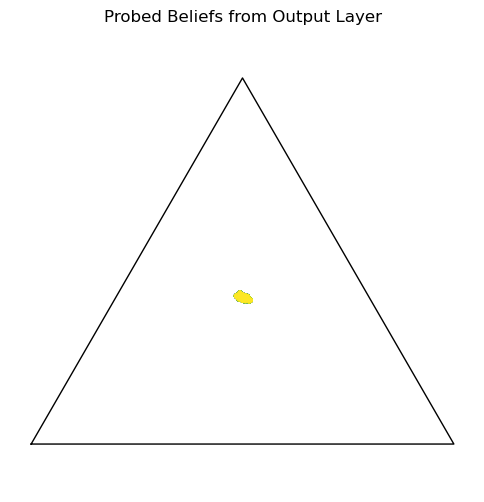

In [28]:
# output_list[0] is [B, T, 3] — already in the correct shape
output = output_list[0]  # [B, T, 3]
X = output.reshape(-1, 3).detach().cpu().numpy()      # [B*T, 3]
Y = true_belief.reshape(-1, 3).detach().cpu().numpy() # [B*T, 3]

# Fit regression
probe = LinearRegression()
probe.fit(X, Y)
Y_pred = probe.predict(X)

# Convert back to tensor and plot
pred_tensor = torch.tensor(Y_pred, dtype=torch.float32)
plot_beliefs_on_simplex(pred_tensor, title="Probed Beliefs from Output Layer")

In [ ]:
class ResidualBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=3, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.BatchNorm1d(channels)
        self.norm2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = self.norm2(x)
        x = self.dropout(self.conv2(x))
        return F.relu(x + residual)

class ResNet1DObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, seq_len = 32, num_blocks=4, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.input_proj = nn.Conv1d(emb_dim, hidden_dim, kernel_size=1)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, emb_dim))  # [1, T, D]
        self.blocks = nn.Sequential(*[
            ResidualBlock1D(hidden_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])

        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)                  # [B, T, D]
        x = x + self.pos_emb[:, :x.size(1), :]  # add position info
        x = x.transpose(1, 2)                  # [B, D, T]
        x = self.input_proj(x)                 # [B, H, T]

        activations = []
        for block in self.blocks:
            x = block(x)
            activations.append(x.transpose(1, 2))  # convert back to [B, T, H]

        logits = self.output(x.transpose(1, 2))    # [B, T, vocab]
        return logits, activations  # [B, T, vocab], [num_layers * [B, T, H]]

In [ ]:
#plot_beliefs_on_simplex(beliefs[:3].cpu(), title="Ground Truth Beliefs")

In [ ]:
tokens = tokens.long()
model = ResNet1DObserver(vocab_size=3, emb_dim=32, hidden_dim=64, num_blocks=6)
model.to(device)

ds = ContinuousHMMDataset(tokens, beliefs, seq_len=32)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, drop_last=True)

print("token entropy:", torch.unique(tokens, return_counts=True))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):
    total_loss = 0
    print("embedding:", model.embedding(tokens[:1]))
    #print("rep layer 0:", activations[0][0, :5])
    for x, y, _ in dl:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, 3), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #print("example logits:", logits[0])
    print(f"Epoch {epoch}: loss = {total_loss:.4f}")

In [ ]:
model.eval()
all_layer_reps = [[] for _ in range(len(model.blocks))]
all_beliefs = []

with torch.no_grad():
    for x, _, beliefs in dl:
        x = x.to(device)
        beliefs = beliefs.to(device)
        _, layer_outputs = model(x)  # list of [B, T, H]

        for i, act in enumerate(layer_outputs):
            all_layer_reps[i].append(act)

        all_beliefs.append(beliefs)

# Stack and reshape
belief_targets = torch.cat(all_beliefs, dim=0).reshape(-1, 3)  # [B*T, 3]

for i, layer_list in enumerate(all_layer_reps):
    reps = torch.cat(layer_list, dim=0).reshape(-1, layer_list[0].shape[-1])  # [B*T, H]

    # Fit linear regression probe
    X = reps.cpu().numpy()
    Y = belief_targets.cpu().numpy()

    probe = LinearRegression().fit(X, Y)
    pred = probe.predict(X)
    pred_tensor = torch.tensor(pred, dtype=torch.float32)

    # Visualize
    plot_beliefs_on_simplex(pred_tensor, title=f"Probed beliefs from Layer {i}")

In [ ]:
class HMMDataset(Dataset):
    def __init__(self, tokens, beliefs, seq_len=32):
        self.seq_len = seq_len
        self.tokens = tokens
        self.beliefs = beliefs
        self.num_samples = len(tokens) - seq_len

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = self.tokens[idx : idx + self.seq_len]
        y = self.tokens[idx + 1 : idx + self.seq_len + 1]
        b = self.beliefs[idx + 1 : idx + self.seq_len + 1]
        return x, y, b

class ResNet1DObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, num_blocks=4, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.input_proj = nn.Conv1d(emb_dim, hidden_dim, kernel_size=1)

        self.blocks = nn.Sequential(*[
            ResidualBlock1D(hidden_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])

        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        """
        x: [B, T] → token indices
        returns: logits [B, T, vocab_size], and hidden features [B, T, hidden_dim]
        """
        x = self.embedding(x)                  # [B, T, D]
        x = x.transpose(1, 2)                  # [B, D, T]
        x = self.input_proj(x)                 # [B, H, T]
        x = self.blocks(x)                     # [B, H, T]
        x = x.transpose(1, 2)                  # [B, T, H]
        logits = self.output(x)                # [B, T, vocab_size]
        return logits, x

lass CNNHMMObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(in_channels=emb_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.output = nn.Linear(hidden_dim, vocab_size)  # for next-token prediction

    def forward(self, x):
        """
        x: LongTensor of shape [B, T]
        Returns:
            logits: [B, T, vocab_size]
            hidden: [B, T, hidden_dim] ← this is our "residual stream"
        """
        x = self.embedding(x)         # [B, T, D]
        x = x.transpose(1, 2)         # [B, D, T] for Conv1d
        x = F.relu(self.conv1(x))     # [B, H, T]
        #x = F.relu(self.conv2(x))     # [B, H, T]
        x = x.transpose(1, 2)         # [B, T, H] back to standard format
        logits = self.output(x)       # [B, T, vocab_size]
        #print("example logits:", logits[0])
        return logits, x              # logits and internal representation
    
class CNNHMMObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(in_channels=emb_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.output = nn.Linear(hidden_dim, vocab_size)  # for next-token prediction

    def forward(self, x):
        """
        x: LongTensor of shape [B, T]
        Returns:
            logits: [B, T, vocab_size]
            hidden: [B, T, hidden_dim] ← this is our "residual stream"
        """
        x = self.embedding(x)         # [B, T, D]
        x = x.transpose(1, 2)         # [B, D, T] for Conv1d
        x = F.relu(self.conv1(x))     # [B, H, T]
        #x = F.relu(self.conv2(x))     # [B, H, T]
        x = x.transpose(1, 2)         # [B, T, H] back to standard format
        logits = self.output(x)       # [B, T, vocab_size]
        #print("example logits:", logits[0])
        return logits, x              # logits and internal representation 